#**MSDS 686 Kaggle Project: Image Classification Using Neural Network Modeling**
#**By Tia Page**

##**Introduction:**

For this Kaggle Project, the dataset titled "Fruits-360 dataset" will be used. This dataset was created and published by Kaggle user Mihai Oltean. The dataset consists of 90,380 images of 131 fruits, vegetables, and nuts. The purpose of this project is to create a neural network model that will accurately predict and classify the images of fruits, vegetables, and nuts. I will first create a code that will build a convolutional neural network (CNN) model that will be used to identify the names of fruits, vegetables, and nuts based on the images that are provided. Then, I will perform a data analysis on the performance of the CNN using model evaluation and plots. Lastly, I will provide a Write-up on the results of the CNN and the steps that were taken to achieve its final accuracy.

## **Data Analysis**

###**Uploading "Fruits-360" dataset from Kaggle:**

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload() # Choose kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tiapageds","key":"36bf83a7dd8161e4af9daca0508d53ad"}'}

In [3]:
# Change permissions of file
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
# Download dataset
! kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 1.28G/1.28G [00:42<00:00, 31.5MB/s]
100% 1.28G/1.28G [00:42<00:00, 32.7MB/s]


In [5]:
# Unzip the downloaded dataset
! unzip -q fruits.zip

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## **Importing necessary packages:**

In [7]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf
from keras import models, layers, backend, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

np.random.seed(1)

## **Data Preparation: Preparing the data by splitting the images into training and validation sets**

In [8]:
# Creating a validation folder with validation images from the training images
train_path = '/content/fruits-360_dataset/fruits-360/Training'
classes = os.listdir(train_path)

val_path = '/content/fruits-360_dataset/fruits-360/Validation'
for cls in classes:
  # Path to the images of the training set
  class_path = os.path.join(train_path, cls)
  # List all image files in class directory
  images = os.listdir(class_path)
  # Split images into training and validation sets (80% training, 20% validation)
  train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
  # Create directory for current class in the validation set if it does not exist
  os.makedirs(os.path.join(val_path, cls), exist_ok=True)
  # Move validation images to the validation folder
  for img in val_images:
    source = os.path.join(class_path, img) # Source files
    destination = os.path.join(val_path, cls, img) # Destination files
    shutil.move(source, destination)

##**Displaying a few sample images from the data set with labels:**

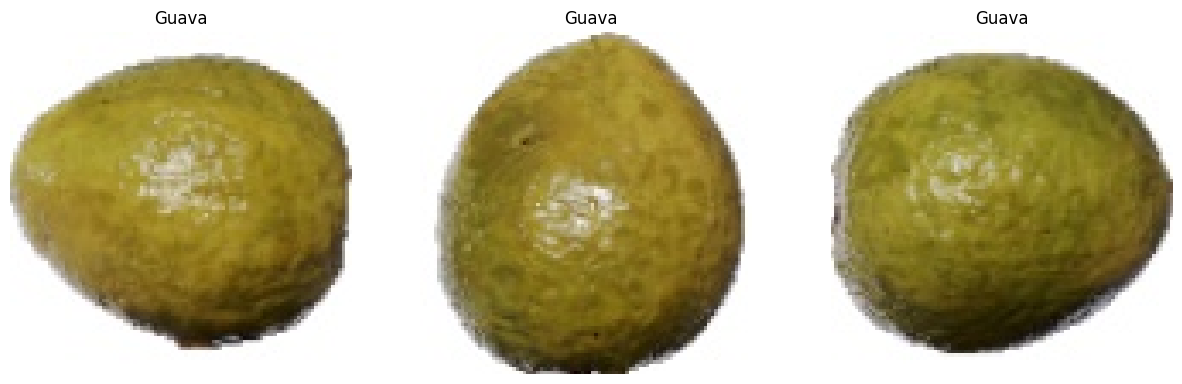

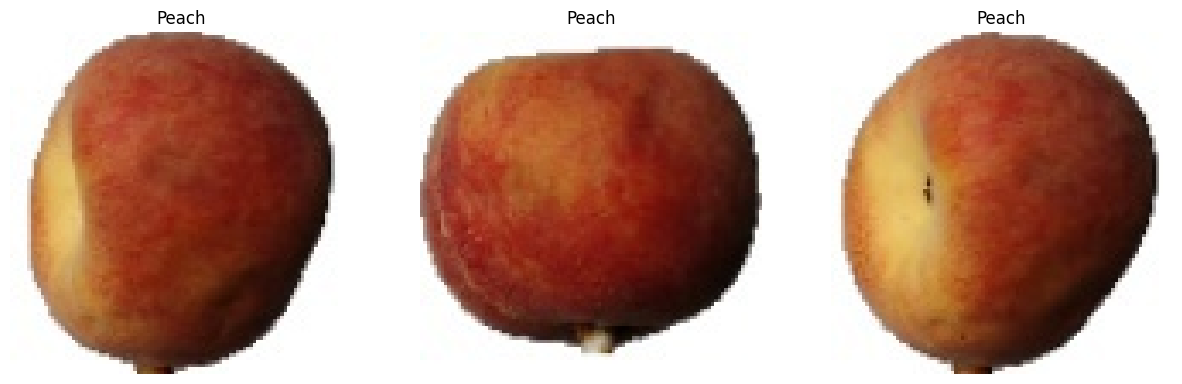

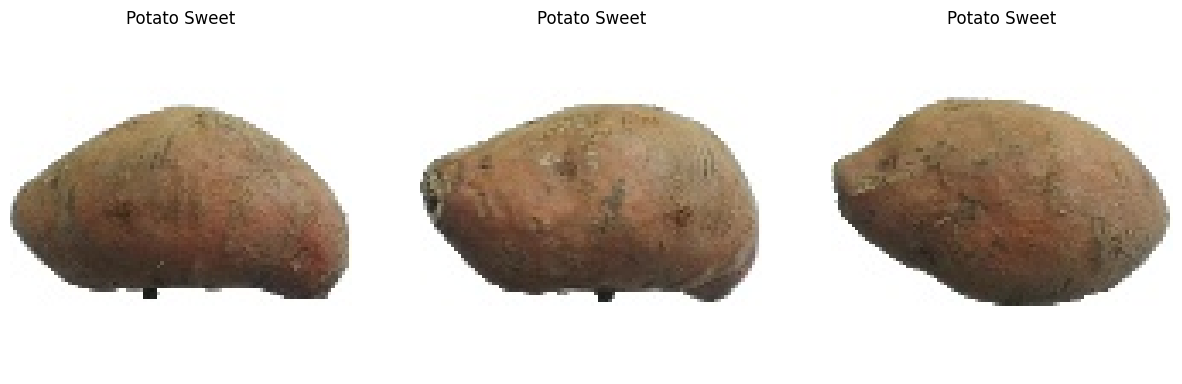

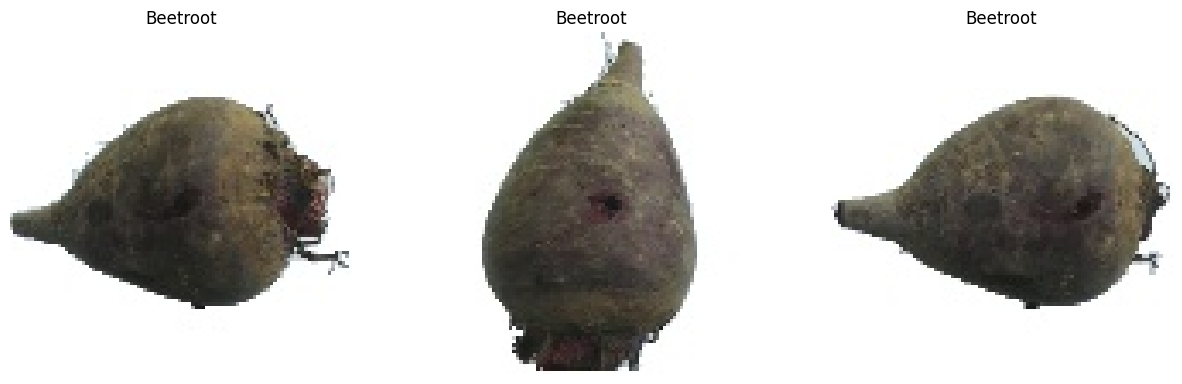

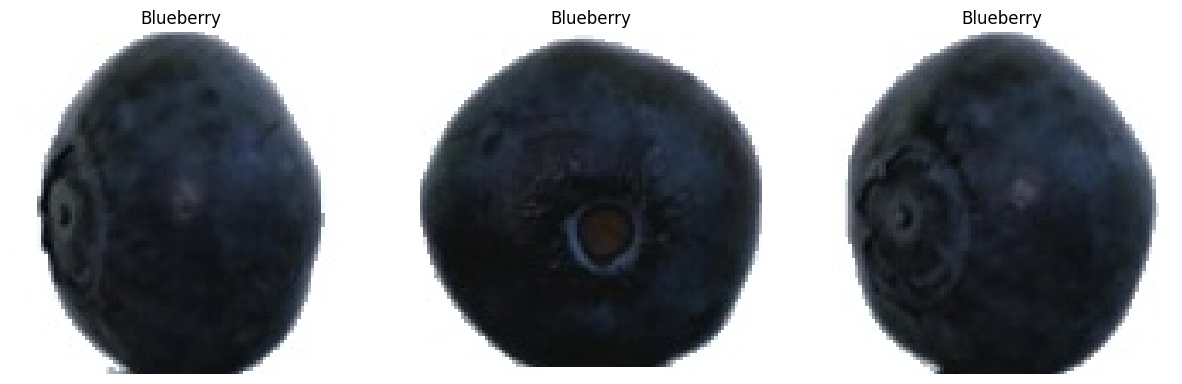

In [9]:
import matplotlib.image as mpimg
import os
import random

# Getting a list of all class folders (fruit types)
class_folders = os.listdir(train_path)

# Selecting 5 random classes from the data set
selected_classes = random.sample(class_folders, 5)

# Number of sample images to show for each class
images_per_class = 3

# Displaying the images and labels for each selected class
for class_name in selected_classes:
    class_path = os.path.join(train_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]

    # Selecting random sample images from the class
    sample_images = random.sample(image_files, min(images_per_class, len(image_files)))

    plt.figure(figsize=(15, 5))
    # The for loop was indented one level too deep, causing the error.
    for i, image_file in enumerate(sample_images):
        image_path = os.path.join(class_path, image_file)
        img = mpimg.imread(image_path)
        plt.subplot(1, images_per_class, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    # Displaying all plots at once
    plt.show()

## **Building and training the Convolutional Neural Network (CNN) model to classify each image:**

In [10]:
# Importing necessary libraries to build the CNN model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [11]:
# Setting image dimensions
img_width, img_height = 100, 100

# Data Augmentation: Creating data generators for training and validation sets with more augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Add rotation
    width_shift_range=0.2,  # Add width shift
    height_shift_range=0.2,  # Add height shift
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # Fill in missing pixels
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Defining the train generator; reduced batch size for faster training
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

# Defining the validation generator; reduced batch size for faster training
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)
# Defining the CNN model
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'), # Added layer
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
        ])

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate optimization: Reducing the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Reduced number of epochs from 20 to 10
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[reduce_lr] # Learning rate optimization: passing the learning rate scheduler here
)

Found 54111 images belonging to 131 classes.
Found 13581 images belonging to 131 classes.
Epoch 1/10
1690/1690 [==============================] - 220s 126ms/step - loss: 2.3115 - accuracy: 0.3480 - val_loss: 0.4963 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 2/10
1690/1690 [==============================] - 214s 127ms/step - loss: 1.0686 - accuracy: 0.6390 - val_loss: 0.2483 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 3/10
1690/1690 [==============================] - 204s 121ms/step - loss: 0.8270 - accuracy: 0.7160 - val_loss: 0.2020 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 4/10
1690/1690 [==============================] - 206s 122ms/step - loss: 0.6906 - accuracy: 0.7601 - val_loss: 0.1117 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 5/10
1690/1690 [==============================] - 204s 121ms/step - loss: 0.6166 - accuracy: 0.7888 - val_loss: 0.1346 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 6/10
1690/1690 [==============================] - 226s 133ms/step - loss: 0.5420 - accuracy: 0.8153

## **Plot of training and validation accuracy vs. number of epochs**


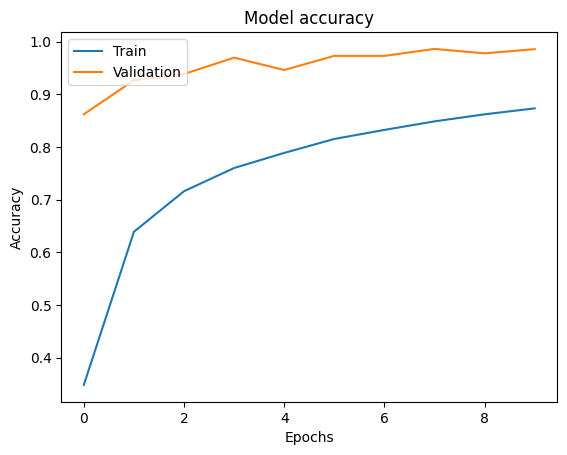

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Plot of training and validation loss vs. number of epochs:**

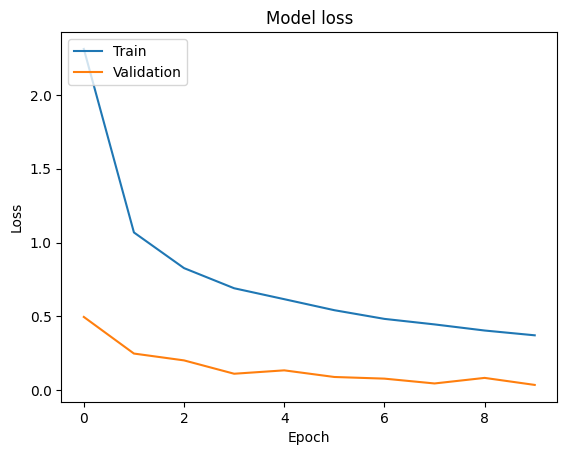

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Plot of sample incorrect prediction with labels and correct label:**

Found 22688 images belonging to 131 classes.
709/709 [==============================] - 13s 18ms/step


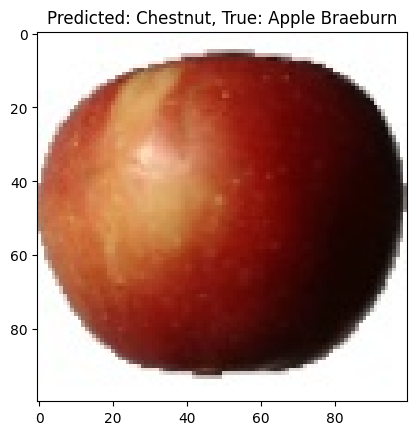

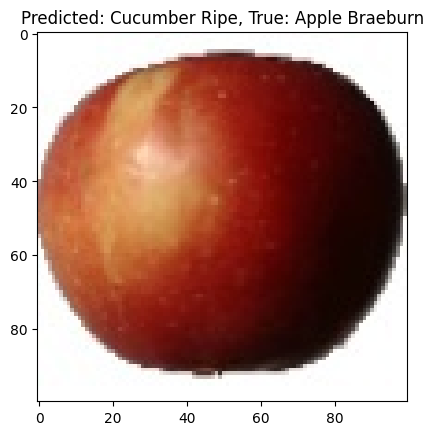

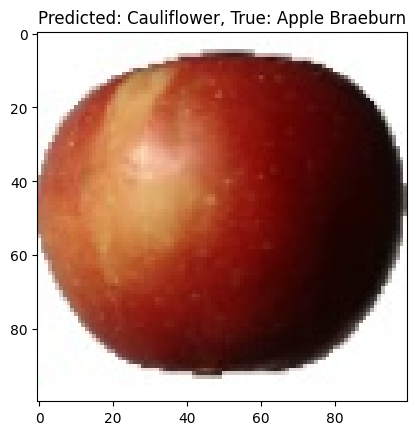

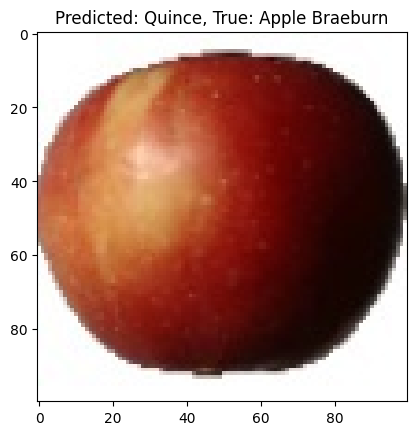

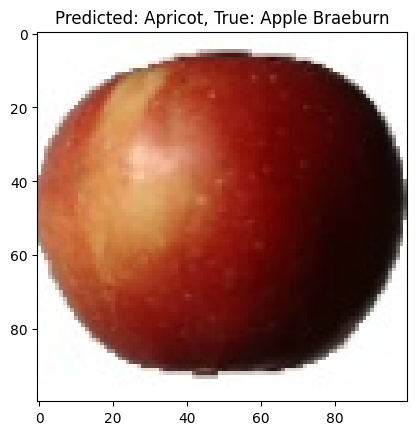

In [28]:
# Creating a path to the test images
test_path = '/content/fruits-360_dataset/fruits-360/Test'
os.makedirs(test_path, exist_ok=True)

# Setting image dimensions
img_width, img_height = 100, 100


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

# Getting the predictions for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Getting the true labels for the test set
true_classes = test_generator.classes

# Finding the incorrect predictions
incorrect_indices = np.nonzero(predicted_classes != true_classes)[0]

# Displaying some of the incorrect predictions
num_samples_to_display = 5

# Getting a list of class names
class_names = list(test_generator.class_indices.keys())
for i in range(min(num_samples_to_display, len(incorrect_indices))):
    index = incorrect_indices[i]

    # Getting the image
    img_path = test_generator.filepaths[index]
    img = plt.imread(img_path)

    # Get predicted and true class indices
    predicted_class_index = predicted_classes[index]
    true_class_index = true_classes[index]

    # Mapping indices to class names using the class_names list
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    # Showing the predicted and true images
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name}, True: {true_class_name}")
    plt.show()

## **Evaluating the model on test data:**

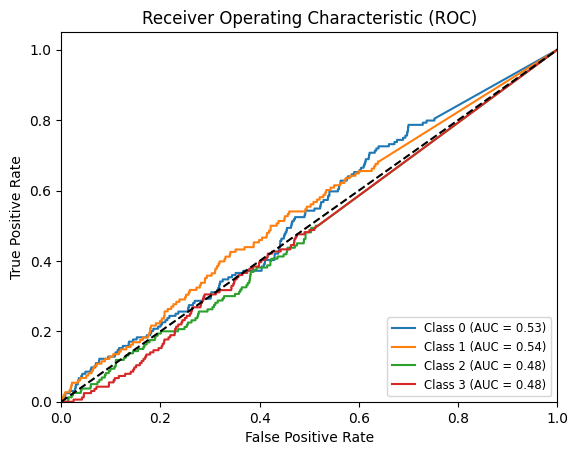

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Calculating ROC curve for each class, but limit to 4 classes
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes_to_plot = min(4, predictions.shape[1])  # Plot up to 4 classes
for i in range(n_classes_to_plot):
    fpr[i], tpr[i], _ = roc_curve(true_classes == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for the selected classes
plt.figure()
for i in range(n_classes_to_plot):
    plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right", fontsize='small')
plt.show()

In [35]:
# Obtaining the loss and accuracy rates of the test data
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

709/709 [==============================] - 14s 19ms/step - loss: 0.1318 - accuracy: 0.9609
Test Loss: 0.13177990913391113
Test Accuracy: 0.9609485268592834


## **Write-up**

### **Overview of assignment:**

The purpose of this project is to classify and identify images of fruits, vegetables, and nuts using a neural network model. For this project, a convolutional neural network (CNN) model in particular was built because this type of model is best suited for problems involving classification and image processing. The overall process of completing this project involved downloading the data directly from Kaggle into Google Colaboratory, building a CNN model from the data, tuning the parameters of the model to improve its performance, than evaluating the performance of the model using a confusion matrix and loss/accuracy calculations.

### **Description of data:**

As briefly discussed in the introduction, the dataset used for this project was created and published by Kaggle user Mihai Oltean. The dataset consists of 90,380 images of 131 fruits, vegetables, and nuts. The data set comes with two folders containing training and test images. It did not come with a folder for valildation data, so a validation data set was created in this project using the training images that were provided.

### **Summary of methods:**

After downloading the dataset from Kaggle into Google Colaboratory, I began building the CNN model and started off by creating a simple structure that included only a few layers. I started with a simple model initially because I wanted to see what the initial accuracy of the model would be using only the basic structure and parameters. My initial model was only composed of two convolutional 2D layers, two max pooling 2D layers, a flatten layer, and two dense layers. The two convolutional 2D layers had 32 and 64 filters respectively. The two dense layers were set to an activation of "relu" and "softmax" respectively. These were the appropriate settings for this dataset specifically because they are best suited for problems involving image classification and processing.

During the training of the model, I set the number of epochs to 20. After training and running the initial (or base) model, the valildation accuracy displayed was 0.8563. While this accuracy value is good, it still has potential to be higher and closer to 100%. I proceeded to make some alterations to the model in order to further increase its accuracy.

To improve the performance of this model, I first added another convolutional 2D layer to the model, added Early Stopping to the code, and decreased the number of epochs being ran from 20 to 10. After running the model again upon making these changes, the validation accuracy increased from 0.8563 to 0.9012. Making this change had already significantly improved my model. Next, I proceeded to incorporate dropout regularization in the CNN model and set the dropout value to 0.5. This randomly drops out or sets a proportion of neurons in a layer to zero in order to prevent overfitting of data. I also increased the batch size of the model from 16 to 32. Making these alterations further improved the model's performance by increasing its accuracy from 0.9012 to 0.9354. Finally, I incorporated data augmentation and learning rate optimization. I created data generators for training and validation sets with more augmentation and set the learning rate of the model to be reduced when the validation loss reaches a plateau. Making these final changes increased the valildation accuracy of the model from 0.9354 to 0.98. The plots of training and validation accuracy vs. number of epochs also further demonstrated the accuracy of the model, in which it showed that the accuracies for both the training and validation data sets continuously increased as the test was ran.


### **Analysis of results:**

After training the validation data, I then performed a model evaluation of the test data using a plot of an ROC curve and performing a calculation of the accuracy and loss of the test data. The ROC curve, based on the four classes that were selected for the plot, showed that most of the data consisted of true positive predictions. True positive means that the prediction was correct and matched with the true value. This was represented by the four ROC curves leaning closer to the "True Positive" axis. The final accuracy of the model (the test accuracy) was 0.9609. This is a very high accuracy and signifies that the CNN model that was built in this project is highly capable of correctly identifying the images of fruits, vegetables, and nuts within the dataset.